# Load Data

In [1]:
%matplotlib inline
from data import get_mnist_dataloaders

from diffusion.transition import (
    linear_beta_schedule,
    build_all_transition_matrices,
    compute_cumulative_transition_matrices,
    sample_q_xt_given_x0,
    compute_discrete_posterior
)

from models.simple_mlp import SimpleD3PMMLP
from models.cnn import SimpleD3PMCNN

from diffusion.transition import sample_q_xt_given_x0, compute_discrete_posterior
from diffusion.reverse import compute_p_theta_xtminus1_given_xt_from_p_tilde

from training.train_one_epoch import train_one_epoch
from training.trainer import Trainer

import torch
import torch.nn.functional as F


In [2]:
device = 'cuda'

In [3]:
train_loader, test_loader = get_mnist_dataloaders(
    batch_size=128,
    # train_subset_size=10000,
    # test_subset_size=200,
    data_root="./data",
    threshold=0.5
)

In [4]:
# Shape is (batch_size, channels, height, width)
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [5]:
# Black or white pixels rather than greyscale
print(torch.unique(x))

tensor([0, 1])


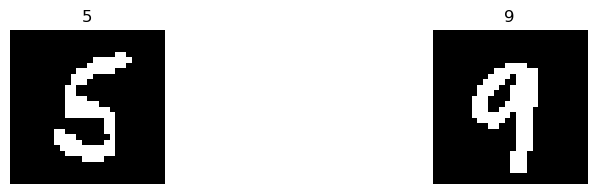

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(x[i].squeeze(), cmap="gray", vmin=0, vmax=1)
    plt.title(y[i].item())
    plt.axis("off")
plt.show()

# Define Transition Matrix for noising

In [7]:
T = 1000

betas = linear_beta_schedule(T).to(device)
Qs = build_all_transition_matrices(betas).to(device)

print(betas.shape)   # torch.Size([100])
print(Qs.shape)      # torch.Size([100, 2, 2])
print(Qs[0])
print(Qs[T-1])

torch.Size([1000])
torch.Size([1000, 2, 2])
tensor([[9.9990e-01, 1.0000e-04],
        [1.0000e-04, 9.9990e-01]], device='cuda:0')
tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]], device='cuda:0')


In [8]:
# Define Qbar[t] = Q_1 * Q_2 * ... * Q_t
Qbar = compute_cumulative_transition_matrices(Qs, device=device)   # [T,2,2]

In [9]:
print("Qbar[2]:\n", Qbar[1])
print("Qbar[T]:\n", Qbar[T-1])

Qbar[2]:
 tensor([[9.9930e-01, 7.0028e-04],
        [7.0028e-04, 9.9930e-01]], device='cuda:0')
Qbar[T]:
 tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]], device='cuda:0')


# Noise Data and Visualise

In [10]:
x[0].shape

torch.Size([1, 28, 28])

In [11]:
timesteps = [0, 5, 10, 30, T//2, 3*T//4, T-1]

results = []   # list of [(t, x_t_batch)]

for t in timesteps:
    xt_batch = sample_q_xt_given_x0(x, t=t, Qbar=Qbar)
    results.append((t, xt_batch.cpu()))

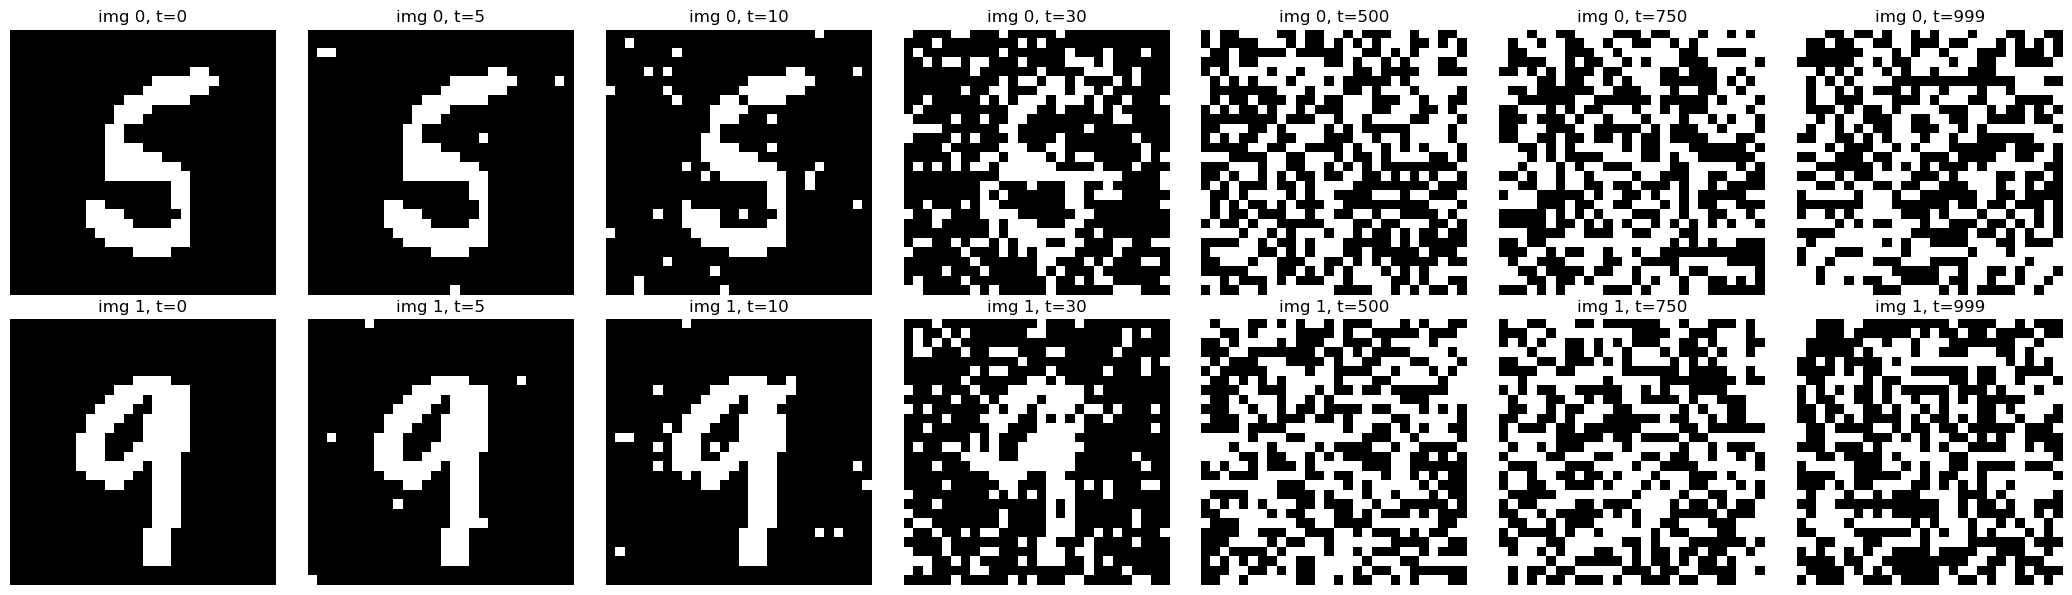

In [12]:
num_images = 2       # = 2
num_steps = len(timesteps)

plt.figure(figsize=(3 * num_steps, 3 * num_images))

for img_idx in range(num_images):  # loop over images in the batch
    for step_idx, (t, xt_batch) in enumerate(results):
        plt.subplot(num_images, num_steps, img_idx * num_steps + step_idx + 1)
        plt.imshow(xt_batch[img_idx].squeeze(), cmap="gray", vmin=0, vmax=1)
        plt.title(f"img {img_idx}, t={t}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
# Compute posterior Q(x_{t-1} | x_t, x_0) for t=99
t = 30   # random example
xt = sample_q_xt_given_x0(x, t=t, Qbar=Qbar)


q_posterior = compute_discrete_posterior(xt, x, t=t, Qs=Qs, Qbar=Qbar)

In [14]:
q_posterior.shape # (batch_size, channels, height, width, num_classes)

torch.Size([128, 1, 28, 28, 2])

In [15]:
# Example: get posterior distribution at pixel (2, 2) of first image in batch
q_posterior[0, 0, 5]

tensor([[0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.0654, 0.9346],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.0654, 0.9346],
        [0.0654, 0.9346],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.0654, 0.9346],
        [0.0034, 0.9966],
        [0.0034, 0.9966],
        [0.0034, 0.9966],
        [0.0034, 0.9966],
        [0.0034, 0.9966],
        [0.0034, 0.9966],
        [0.0034, 0.9966],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.0654, 0.9346],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034]], device='cuda:0')

# Initialize model to predict posterior

In [16]:
model = SimpleD3PMMLP(T=T).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [19]:
x = x.to(device)
t = torch.randint(1, T, (x.shape[0],), device=device)   # shape [B]

In [20]:
xt = sample_q_xt_given_x0(x, t, Qbar).to(device)        # [B,1,28,28]

In [21]:
xt.shape

torch.Size([128, 1, 28, 28])

In [22]:
# this is p̃_theta(x0 | x_t))
logits_x0 = model(xt, t).to(device)

In [23]:
logits_x0.shape

torch.Size([128, 2, 28, 28])

In [24]:
# compute eqn (4)
p_theta = compute_p_theta_xtminus1_given_xt_from_p_tilde(logits_x0, xt, t, Qs, Qbar)   

In [25]:
p_theta.shape

torch.Size([128, 1, 28, 28, 2])

In [26]:
p_theta[0,0,1,1]

tensor([0.2980, 0.7020], device='cuda:0', grad_fn=<SelectBackward0>)

In [27]:
# KL divergence between q_posterior and p_theta
log_q = torch.log(q_posterior + 1e-20)
log_p = torch.log(p_theta + 1e-20)
kl = (q_posterior * (log_q - log_p)).sum(dim=-1).mean()

In [26]:
# auxilary term is CE
p_tilde = F.softmax(logits_x0, dim=1).to(device)         # [B,2,28,28]
p_x0 = p_tilde.gather(1, x)                  # [B,1,28,28]
aux_ce = -(torch.log(p_x0 + 1e-20)).mean()

In [27]:
lambda_aux = 0.1  # (arbitraty)
loss = kl + lambda_aux * aux_ce

loss

tensor(0.9603, device='cuda:0', grad_fn=<AddBackward0>)

In [28]:
# # ----- 10. Backprop + optimizer step -----
optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f"loss={loss.item():.4f}, kl={kl.item():.4f}, aux_ce={aux_ce.item():.4f}, t_mean={t.float().mean().item():.1f}")

loss=0.9603, kl=0.8909, aux_ce=0.6941, t_mean=483.4


# Use a trainer to call train_one_epoch internally

In [20]:
T=1000

In [21]:
model = SimpleD3PMMLP(T=T).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
# Create trainer
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=test_loader,   # optional
    Qs=Qs,
    Qbar=Qbar,
    T=T,
    device=device,
    lambda_aux=0.01,
    ckpt_dir="./training/checkpoints"
)


Epoch 1/30
  loss: 0.0033
  L_tminus1: 0.0003
  L0: 0.0003
  aux_ce: 0.2690
  steps: 469.0000
  lr: 0.0010

  Denoising metrics on full train set:
    At t=30:
      pixel_acc: 0.8689
      fg_acc: 0.0845
      bg_acc: 0.9885
      balanced_acc: 0.5365
      hamming: 0.1311
      mae: 0.1311
    At t=999 (final):
      pixel_acc: 0.8687
      fg_acc: 0.0938
      bg_acc: 0.9868
      balanced_acc: 0.5403
      hamming: 0.1313
      mae: 0.1313


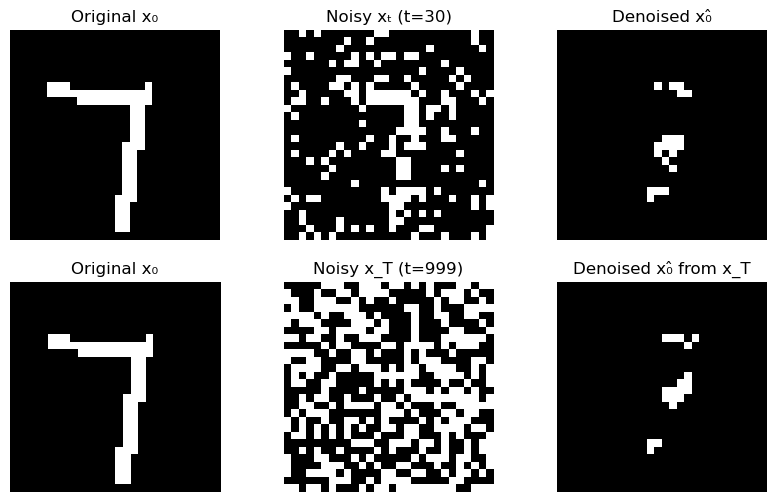


Epoch 3/30
  loss: 0.0031
  L_tminus1: 0.0002
  L0: 0.0003
  aux_ce: 0.2626
  steps: 469.0000
  lr: 0.0010

  Denoising metrics on full train set:
    At t=30:
      pixel_acc: 0.8937
      fg_acc: 0.4099
      bg_acc: 0.9674
      balanced_acc: 0.6887
      hamming: 0.1063
      mae: 0.1063
    At t=999 (final):
      pixel_acc: 0.8687
      fg_acc: 0.1138
      bg_acc: 0.9838
      balanced_acc: 0.5488
      hamming: 0.1313
      mae: 0.1313


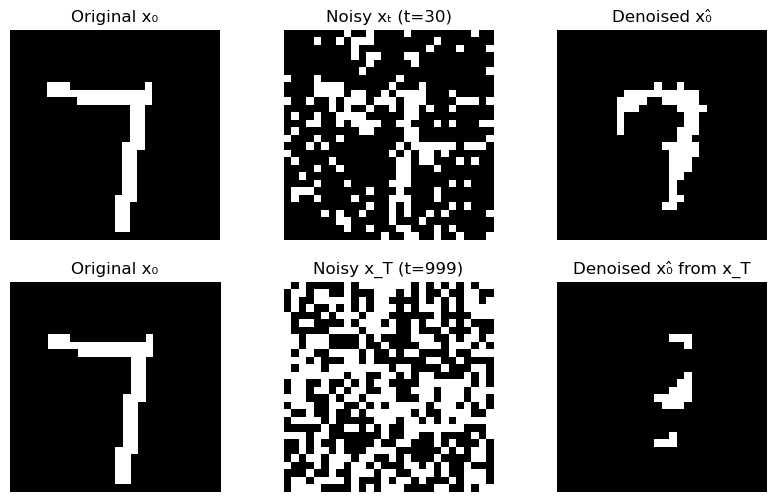


Epoch 6/30
  loss: 0.0030
  L_tminus1: 0.0002
  L0: 0.0002
  aux_ce: 0.2598
  steps: 469.0000
  lr: 0.0009

  Denoising metrics on full train set:
    At t=30:
      pixel_acc: 0.9115
      fg_acc: 0.6986
      bg_acc: 0.9440
      balanced_acc: 0.8213
      hamming: 0.0885
      mae: 0.0885
    At t=999 (final):
      pixel_acc: 0.8688
      fg_acc: 0.1096
      bg_acc: 0.9846
      balanced_acc: 0.5471
      hamming: 0.1312
      mae: 0.1312


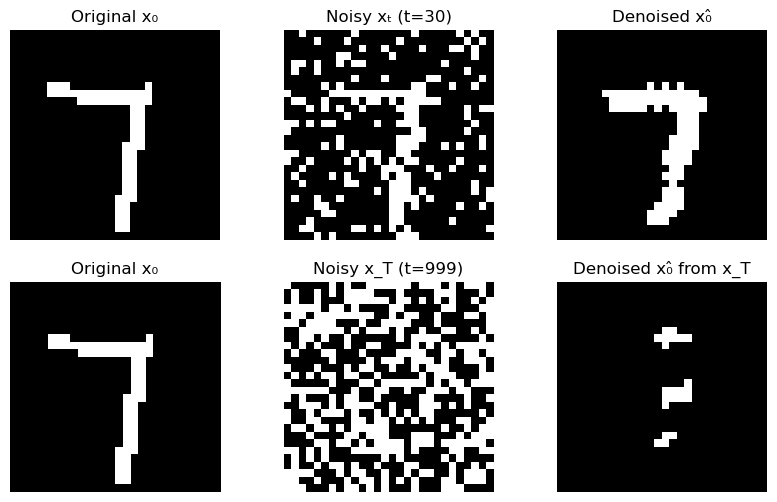


Epoch 9/30
  loss: 0.0030
  L_tminus1: 0.0002
  L0: 0.0002
  aux_ce: 0.2588
  steps: 469.0000
  lr: 0.0008

  Denoising metrics on full train set:
    At t=30:
      pixel_acc: 0.9202
      fg_acc: 0.6066
      bg_acc: 0.9680
      balanced_acc: 0.7873
      hamming: 0.0798
      mae: 0.0798
    At t=999 (final):
      pixel_acc: 0.8685
      fg_acc: 0.1022
      bg_acc: 0.9853
      balanced_acc: 0.5438
      hamming: 0.1315
      mae: 0.1315


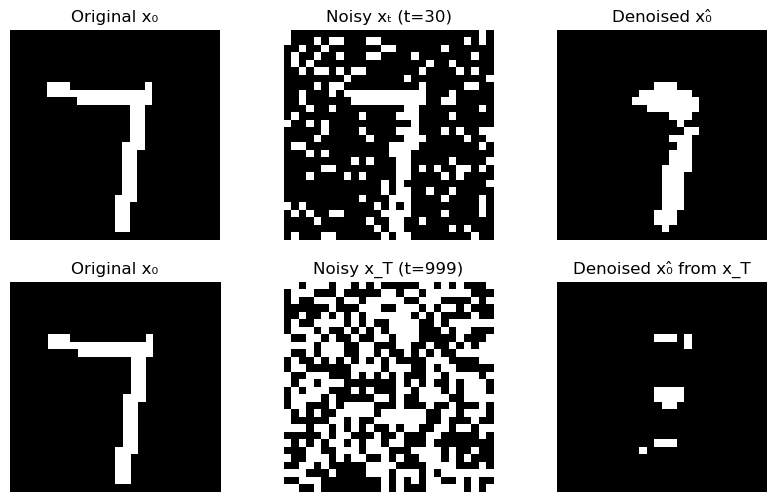


Epoch 12/30
  loss: 0.0029
  L_tminus1: 0.0002
  L0: 0.0001
  aux_ce: 0.2580
  steps: 469.0000
  lr: 0.0007

  Denoising metrics on full train set:
    At t=30:
      pixel_acc: 0.9252
      fg_acc: 0.7075
      bg_acc: 0.9583
      balanced_acc: 0.8329
      hamming: 0.0748
      mae: 0.0748
    At t=999 (final):
      pixel_acc: 0.8689
      fg_acc: 0.1356
      bg_acc: 0.9806
      balanced_acc: 0.5581
      hamming: 0.1311
      mae: 0.1311


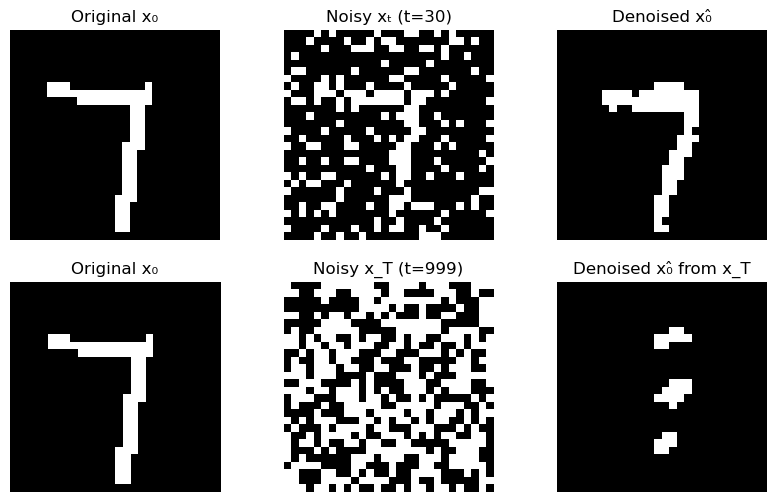


Epoch 15/30
  loss: 0.0029
  L_tminus1: 0.0002
  L0: 0.0001
  aux_ce: 0.2574
  steps: 469.0000
  lr: 0.0005

  Denoising metrics on full train set:
    At t=30:
      pixel_acc: 0.9300
      fg_acc: 0.7216
      bg_acc: 0.9617
      balanced_acc: 0.8416
      hamming: 0.0700
      mae: 0.0700
    At t=999 (final):
      pixel_acc: 0.8690
      fg_acc: 0.1131
      bg_acc: 0.9842
      balanced_acc: 0.5486
      hamming: 0.1310
      mae: 0.1310


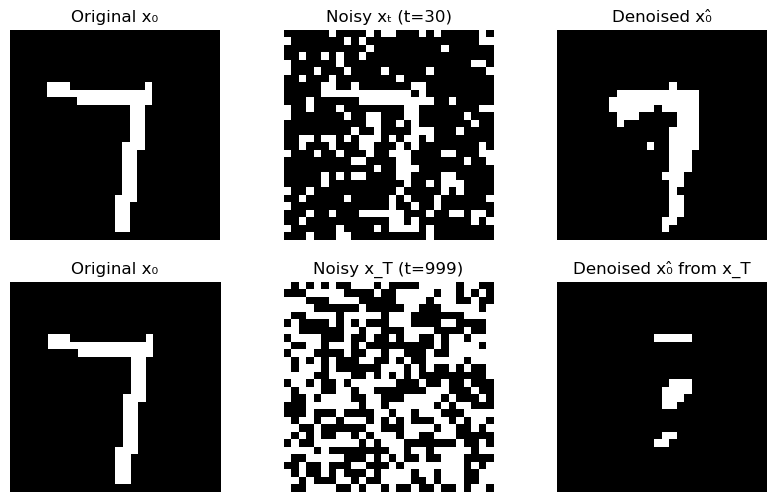


Epoch 18/30
  loss: 0.0029
  L_tminus1: 0.0002
  L0: 0.0001
  aux_ce: 0.2571
  steps: 469.0000
  lr: 0.0003

  Denoising metrics on full train set:
    At t=30:
      pixel_acc: 0.9317
      fg_acc: 0.7339
      bg_acc: 0.9618
      balanced_acc: 0.8479
      hamming: 0.0683
      mae: 0.0683
    At t=999 (final):
      pixel_acc: 0.8689
      fg_acc: 0.1162
      bg_acc: 0.9836
      balanced_acc: 0.5499
      hamming: 0.1311
      mae: 0.1311


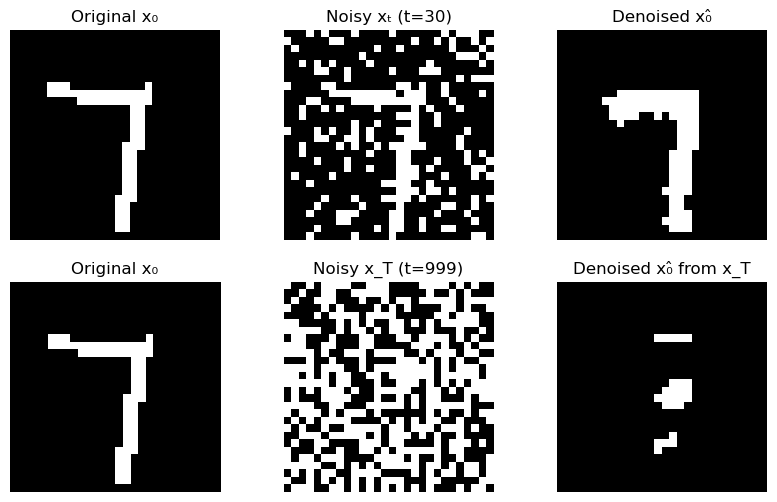


Epoch 21/30
  loss: 0.0029
  L_tminus1: 0.0001
  L0: 0.0001
  aux_ce: 0.2570
  steps: 469.0000
  lr: 0.0002

  Denoising metrics on full train set:
    At t=30:
      pixel_acc: 0.9351
      fg_acc: 0.7101
      bg_acc: 0.9694
      balanced_acc: 0.8397
      hamming: 0.0649
      mae: 0.0649
    At t=999 (final):
      pixel_acc: 0.8690
      fg_acc: 0.0984
      bg_acc: 0.9865
      balanced_acc: 0.5425
      hamming: 0.1310
      mae: 0.1310


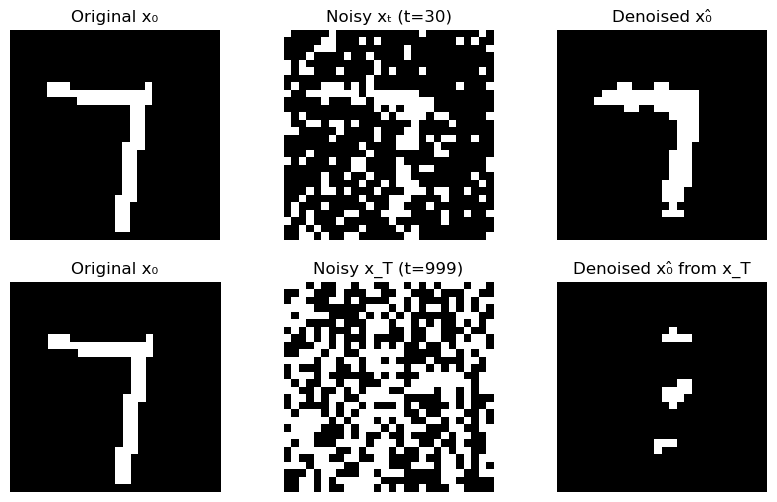


Epoch 24/30
  loss: 0.0029
  L_tminus1: 0.0001
  L0: 0.0001
  aux_ce: 0.2568
  steps: 469.0000
  lr: 0.0001

  Denoising metrics on full train set:
    At t=30:
      pixel_acc: 0.9365
      fg_acc: 0.7099
      bg_acc: 0.9710
      balanced_acc: 0.8404
      hamming: 0.0635
      mae: 0.0635
    At t=999 (final):
      pixel_acc: 0.8690
      fg_acc: 0.1077
      bg_acc: 0.9851
      balanced_acc: 0.5464
      hamming: 0.1310
      mae: 0.1310


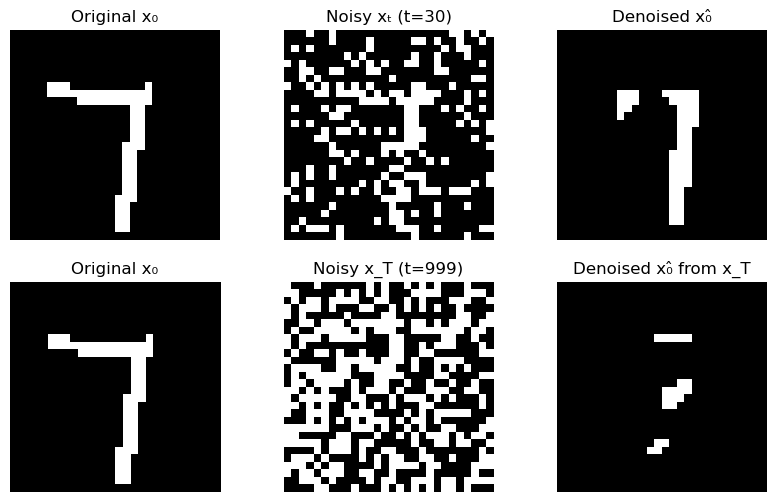


Epoch 27/30
  loss: 0.0028
  L_tminus1: 0.0001
  L0: 0.0001
  aux_ce: 0.2566
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    At t=30:
      pixel_acc: 0.9375
      fg_acc: 0.7167
      bg_acc: 0.9712
      balanced_acc: 0.8439
      hamming: 0.0625
      mae: 0.0625
    At t=999 (final):
      pixel_acc: 0.8690
      fg_acc: 0.1057
      bg_acc: 0.9854
      balanced_acc: 0.5455
      hamming: 0.1310
      mae: 0.1310


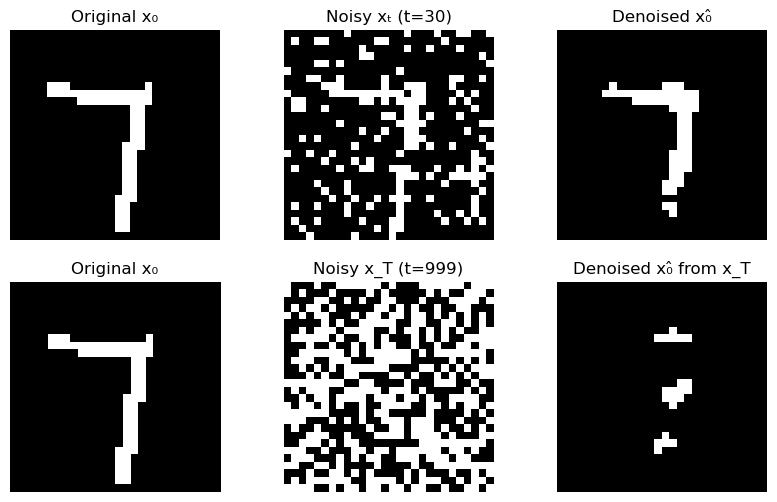


Epoch 30/30
  loss: 0.0028
  L_tminus1: 0.0001
  L0: 0.0001
  aux_ce: 0.2563
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    At t=30:
      pixel_acc: 0.9378
      fg_acc: 0.7270
      bg_acc: 0.9699
      balanced_acc: 0.8484
      hamming: 0.0622
      mae: 0.0622
    At t=999 (final):
      pixel_acc: 0.8690
      fg_acc: 0.1035
      bg_acc: 0.9857
      balanced_acc: 0.5446
      hamming: 0.1310
      mae: 0.1310


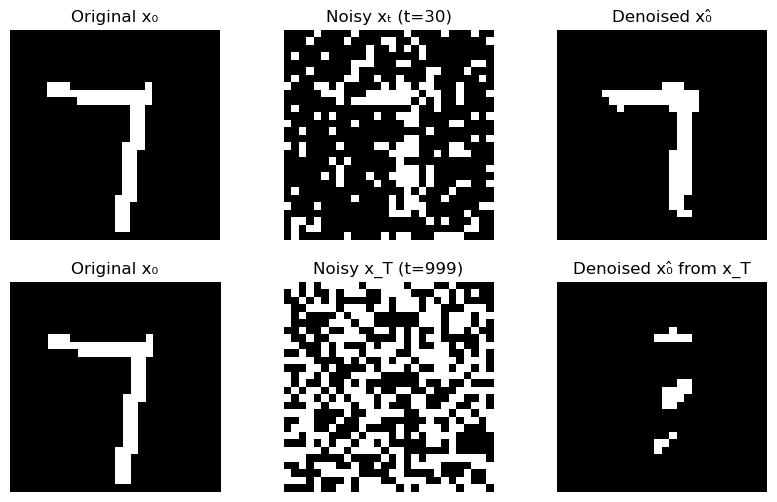

In [23]:
# New code
history = trainer.train(num_epochs=30, save_every=None, validate=False, print_every=3)

# lambda 0.1

In [21]:
model = SimpleD3PMMLP(T=T).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
# Create trainer
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=test_loader,   # optional
    Qs=Qs,
    Qbar=Qbar,
    T=T,
    device=device,
    lambda_aux=0.1,
    ckpt_dir="./training/checkpoints"
)


Epoch 1/30
  loss: 0.0274
  L_tminus1: 0.0003
  L0: 0.0003
  aux_ce: 0.2680
  steps: 469.0000
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.8692
    fg_acc: 0.1256
    bg_acc: 0.9826
    balanced_acc: 0.5541
    hamming: 0.1308
    mae: 0.1308


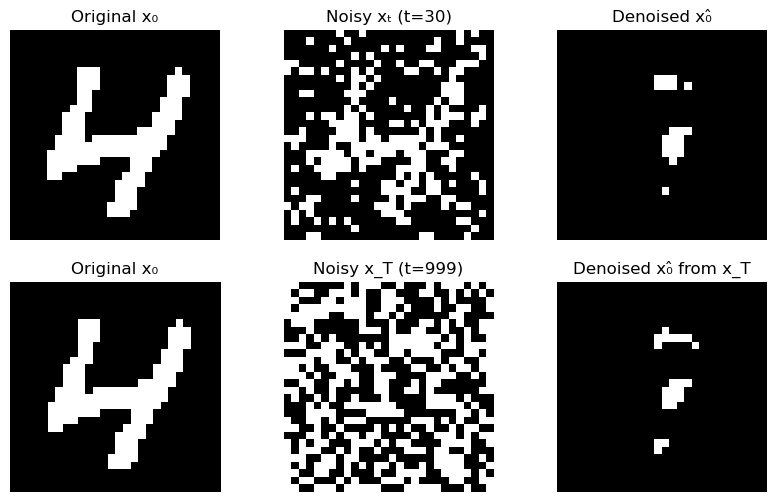


Epoch 3/30
  loss: 0.0267
  L_tminus1: 0.0002
  L0: 0.0003
  aux_ce: 0.2623
  steps: 469.0000
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.8946
    fg_acc: 0.4424
    bg_acc: 0.9635
    balanced_acc: 0.7030
    hamming: 0.1054
    mae: 0.1054


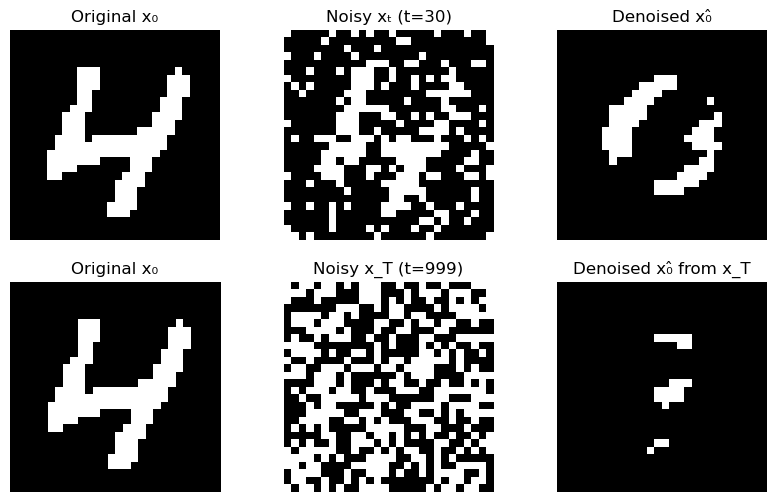


Epoch 6/30
  loss: 0.0263
  L_tminus1: 0.0002
  L0: 0.0002
  aux_ce: 0.2592
  steps: 469.0000
  lr: 0.0009

  Denoising metrics on full train set:
    pixel_acc: 0.9160
    fg_acc: 0.5528
    bg_acc: 0.9714
    balanced_acc: 0.7621
    hamming: 0.0840
    mae: 0.0840


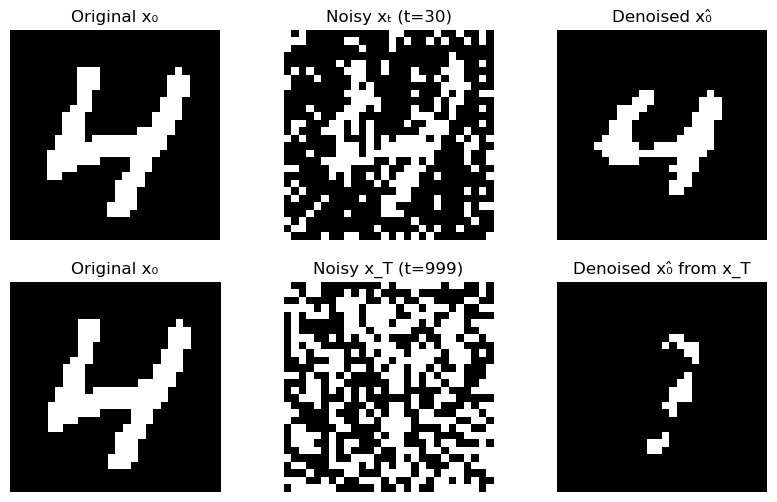


Epoch 9/30
  loss: 0.0261
  L_tminus1: 0.0002
  L0: 0.0002
  aux_ce: 0.2578
  steps: 469.0000
  lr: 0.0008

  Denoising metrics on full train set:
    pixel_acc: 0.9293
    fg_acc: 0.6791
    bg_acc: 0.9674
    balanced_acc: 0.8232
    hamming: 0.0707
    mae: 0.0707


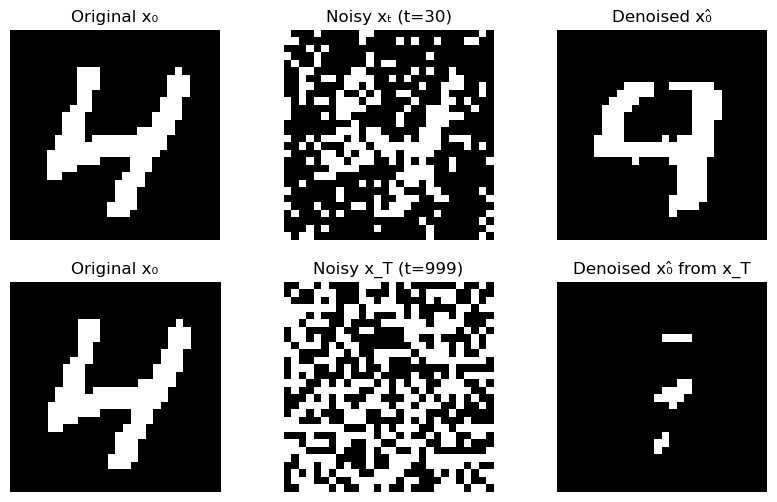


Epoch 12/30
  loss: 0.0260
  L_tminus1: 0.0002
  L0: 0.0001
  aux_ce: 0.2572
  steps: 469.0000
  lr: 0.0007

  Denoising metrics on full train set:
    pixel_acc: 0.9336
    fg_acc: 0.7349
    bg_acc: 0.9639
    balanced_acc: 0.8494
    hamming: 0.0664
    mae: 0.0664


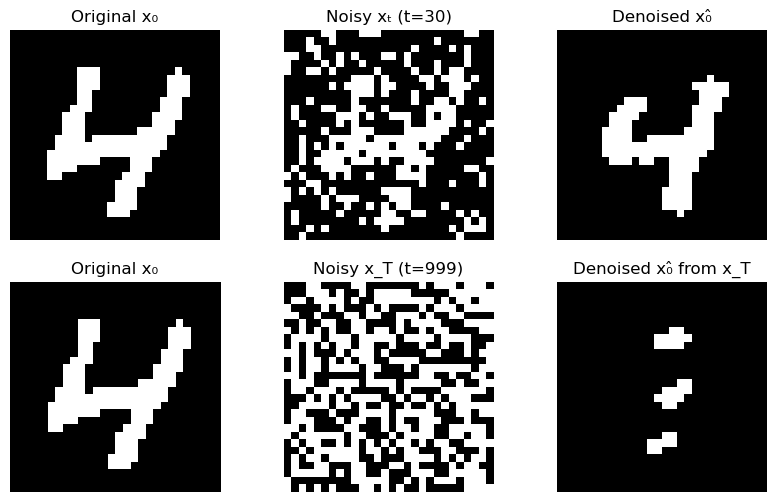


Epoch 15/30
  loss: 0.0259
  L_tminus1: 0.0002
  L0: 0.0001
  aux_ce: 0.2567
  steps: 469.0000
  lr: 0.0005

  Denoising metrics on full train set:
    pixel_acc: 0.9375
    fg_acc: 0.7316
    bg_acc: 0.9689
    balanced_acc: 0.8503
    hamming: 0.0625
    mae: 0.0625


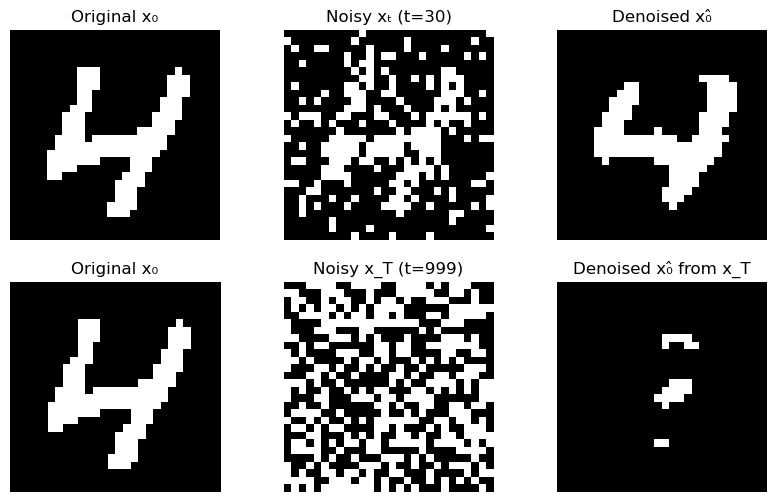


Epoch 18/30
  loss: 0.0259
  L_tminus1: 0.0001
  L0: 0.0001
  aux_ce: 0.2563
  steps: 469.0000
  lr: 0.0003

  Denoising metrics on full train set:
    pixel_acc: 0.9398
    fg_acc: 0.7946
    bg_acc: 0.9619
    balanced_acc: 0.8782
    hamming: 0.0602
    mae: 0.0602


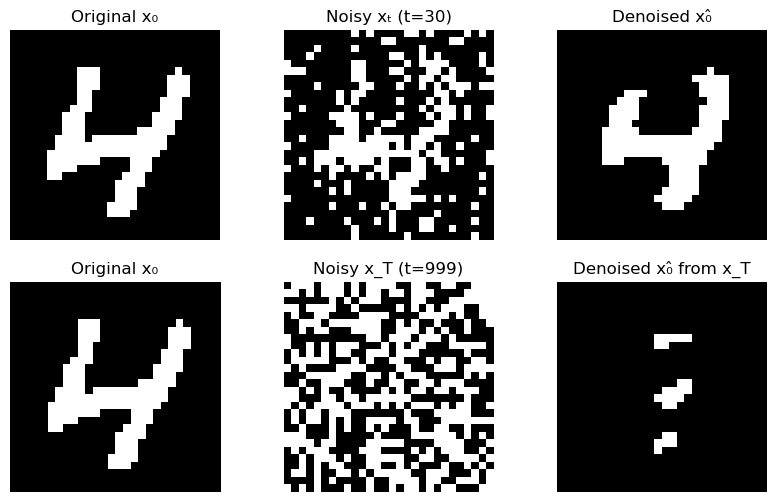


Epoch 21/30
  loss: 0.0258
  L_tminus1: 0.0001
  L0: 0.0001
  aux_ce: 0.2556
  steps: 469.0000
  lr: 0.0002

  Denoising metrics on full train set:
    pixel_acc: 0.9432
    fg_acc: 0.7613
    bg_acc: 0.9709
    balanced_acc: 0.8661
    hamming: 0.0568
    mae: 0.0568


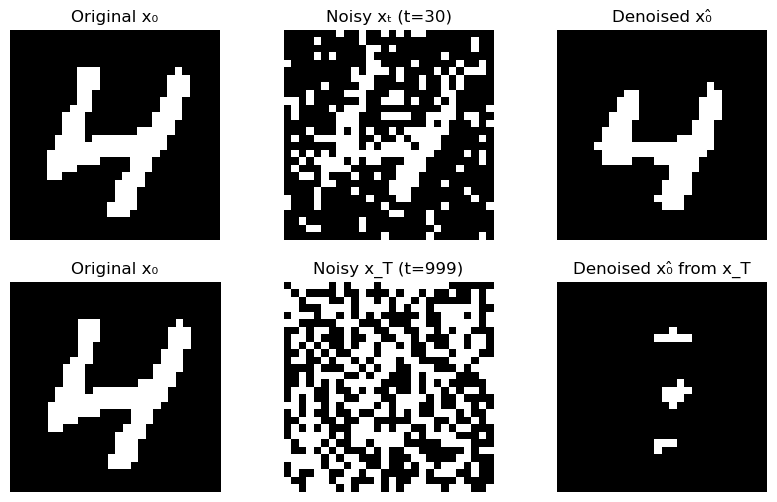


Epoch 24/30
  loss: 0.0258
  L_tminus1: 0.0001
  L0: 0.0001
  aux_ce: 0.2556
  steps: 469.0000
  lr: 0.0001

  Denoising metrics on full train set:
    pixel_acc: 0.9448
    fg_acc: 0.7670
    bg_acc: 0.9719
    balanced_acc: 0.8695
    hamming: 0.0552
    mae: 0.0552


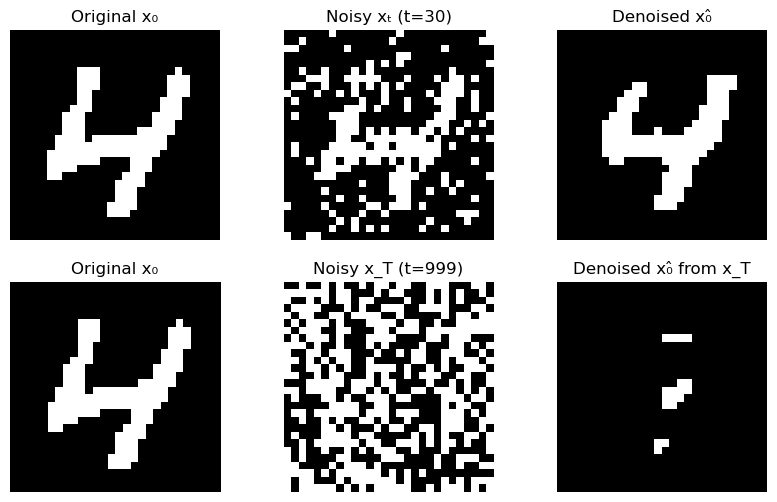


Epoch 27/30
  loss: 0.0258
  L_tminus1: 0.0001
  L0: 0.0001
  aux_ce: 0.2556
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.9456
    fg_acc: 0.7653
    bg_acc: 0.9731
    balanced_acc: 0.8692
    hamming: 0.0544
    mae: 0.0544


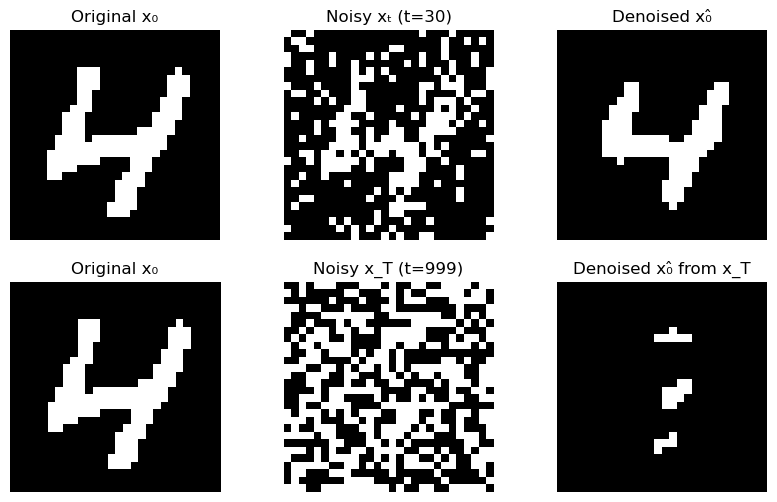


Epoch 30/30
  loss: 0.0257
  L_tminus1: 0.0001
  L0: 0.0001
  aux_ce: 0.2555
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.9458
    fg_acc: 0.7650
    bg_acc: 0.9733
    balanced_acc: 0.8692
    hamming: 0.0542
    mae: 0.0542


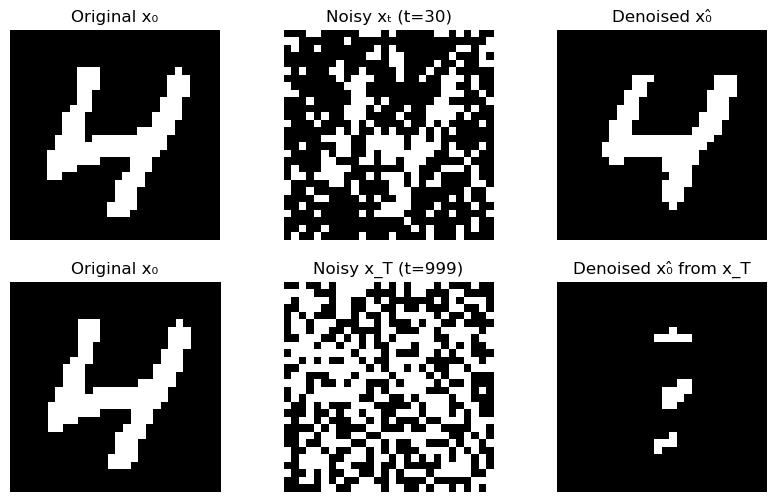

In [23]:
# New code
history = trainer.train(num_epochs=30, save_every=None, validate=False, print_every=3)

# Lambda = 1

In [30]:
model = SimpleD3PMMLP(T=T).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [31]:
# Create trainer
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=test_loader,   # optional
    Qs=Qs,
    Qbar=Qbar,
    T=T,
    device=device,
    lambda_aux=1,
    ckpt_dir="./training/checkpoints"
)


Epoch 1/30
  loss: 0.2682
  kl: 0.0003
  aux_ce: 0.2679
  steps: 469.0000
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.8690
    fg_acc: 0.1950
    bg_acc: 0.9718
    balanced_acc: 0.5834
    hamming: 0.1310
    mae: 0.1310


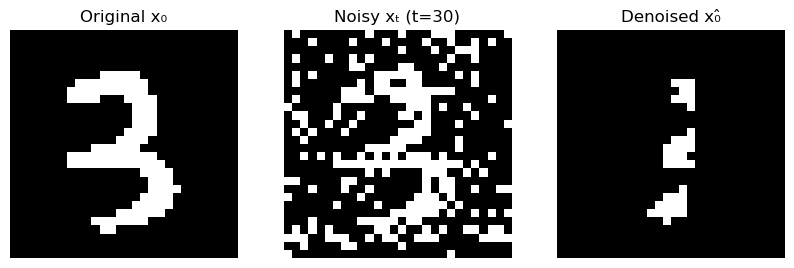


Epoch 3/30
  loss: 0.2622
  kl: 0.0002
  aux_ce: 0.2620
  steps: 469.0000
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.8992
    fg_acc: 0.4987
    bg_acc: 0.9602
    balanced_acc: 0.7295
    hamming: 0.1008
    mae: 0.1008


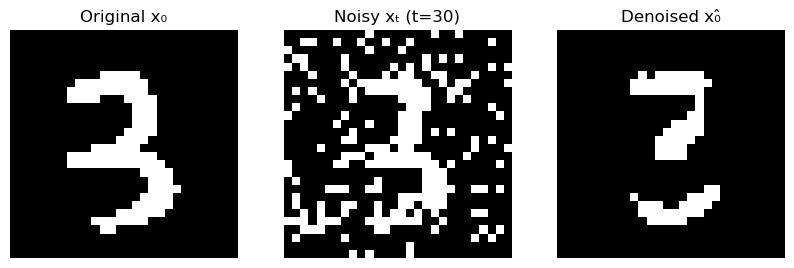


Epoch 6/30
  loss: 0.2590
  kl: 0.0002
  aux_ce: 0.2589
  steps: 469.0000
  lr: 0.0009

  Denoising metrics on full train set:
    pixel_acc: 0.9199
    fg_acc: 0.5895
    bg_acc: 0.9702
    balanced_acc: 0.7799
    hamming: 0.0801
    mae: 0.0801


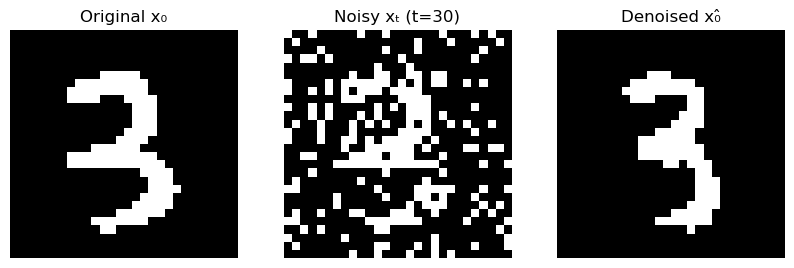


Epoch 9/30
  loss: 0.2580
  kl: 0.0002
  aux_ce: 0.2578
  steps: 469.0000
  lr: 0.0008

  Denoising metrics on full train set:
    pixel_acc: 0.9310
    fg_acc: 0.7010
    bg_acc: 0.9660
    balanced_acc: 0.8335
    hamming: 0.0690
    mae: 0.0690


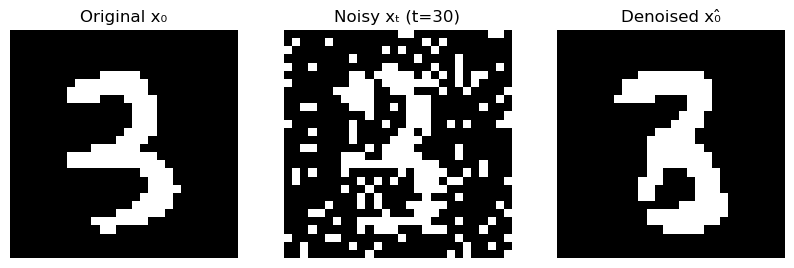


Epoch 12/30
  loss: 0.2572
  kl: 0.0002
  aux_ce: 0.2570
  steps: 469.0000
  lr: 0.0007

  Denoising metrics on full train set:
    pixel_acc: 0.9352
    fg_acc: 0.6931
    bg_acc: 0.9721
    balanced_acc: 0.8326
    hamming: 0.0648
    mae: 0.0648


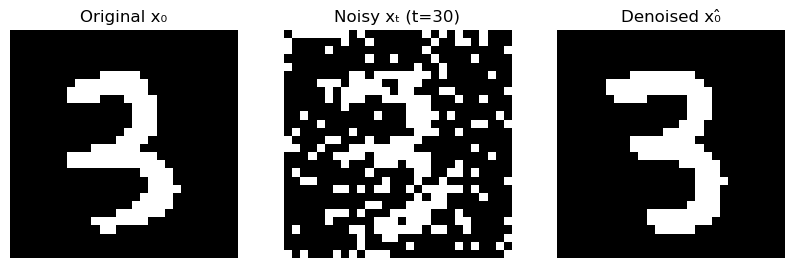


Epoch 15/30
  loss: 0.2567
  kl: 0.0001
  aux_ce: 0.2565
  steps: 469.0000
  lr: 0.0005

  Denoising metrics on full train set:
    pixel_acc: 0.9407
    fg_acc: 0.7506
    bg_acc: 0.9697
    balanced_acc: 0.8601
    hamming: 0.0593
    mae: 0.0593


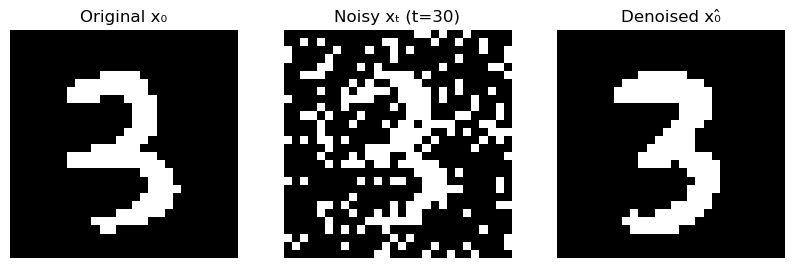


Epoch 18/30
  loss: 0.2560
  kl: 0.0001
  aux_ce: 0.2559
  steps: 469.0000
  lr: 0.0003

  Denoising metrics on full train set:
    pixel_acc: 0.9436
    fg_acc: 0.7639
    bg_acc: 0.9710
    balanced_acc: 0.8674
    hamming: 0.0564
    mae: 0.0564


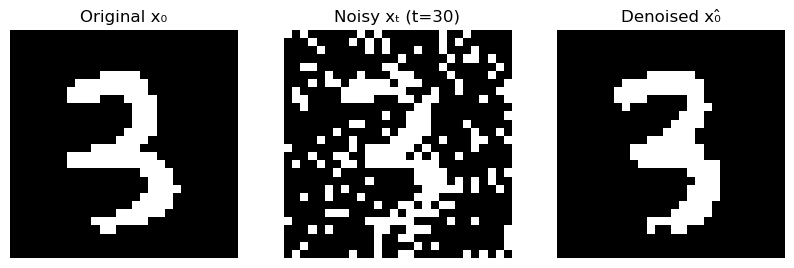


Epoch 21/30
  loss: 0.2557
  kl: 0.0001
  aux_ce: 0.2556
  steps: 469.0000
  lr: 0.0002

  Denoising metrics on full train set:
    pixel_acc: 0.9456
    fg_acc: 0.7653
    bg_acc: 0.9731
    balanced_acc: 0.8692
    hamming: 0.0544
    mae: 0.0544


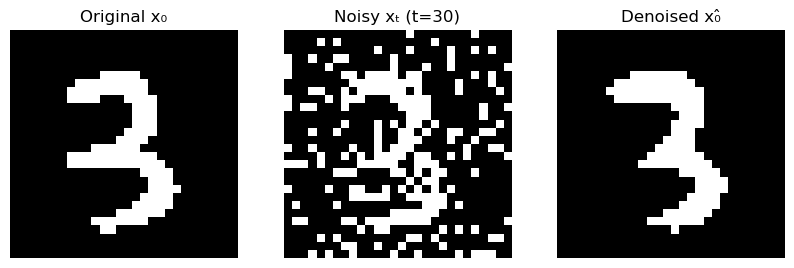


Epoch 24/30
  loss: 0.2554
  kl: 0.0001
  aux_ce: 0.2553
  steps: 469.0000
  lr: 0.0001

  Denoising metrics on full train set:
    pixel_acc: 0.9472
    fg_acc: 0.7865
    bg_acc: 0.9717
    balanced_acc: 0.8791
    hamming: 0.0528
    mae: 0.0528


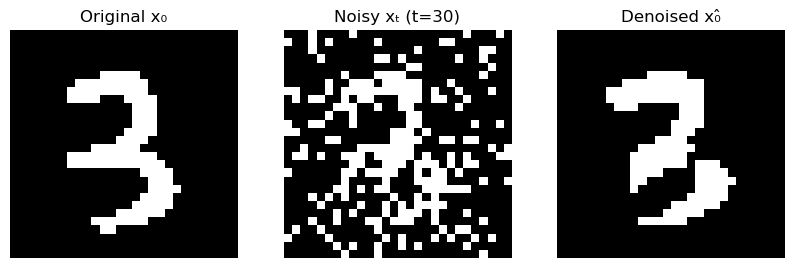


Epoch 27/30
  loss: 0.2553
  kl: 0.0001
  aux_ce: 0.2552
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.9481
    fg_acc: 0.7875
    bg_acc: 0.9726
    balanced_acc: 0.8801
    hamming: 0.0519
    mae: 0.0519


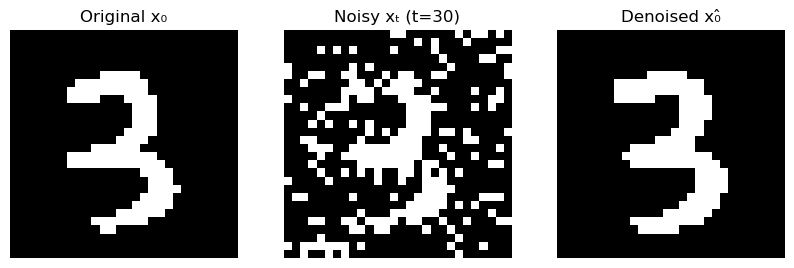


Epoch 30/30
  loss: 0.2552
  kl: 0.0001
  aux_ce: 0.2551
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.9483
    fg_acc: 0.7834
    bg_acc: 0.9735
    balanced_acc: 0.8784
    hamming: 0.0517
    mae: 0.0517


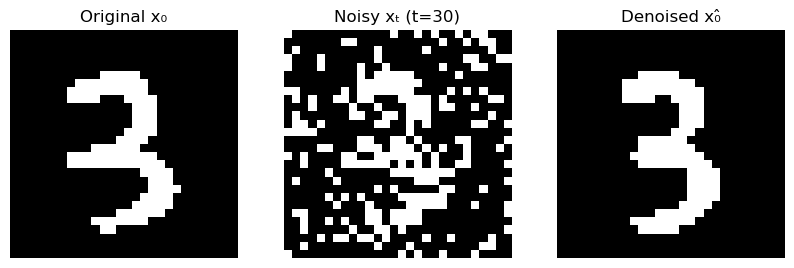

In [32]:
# New code
history = trainer.train(num_epochs=30, save_every=None, validate=False, print_every=3)

## CNN

In [27]:
cnn_model = SimpleD3PMCNN(T=T).to(device)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

In [28]:
# Create trainer
trainer = Trainer(
    model=cnn_model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=test_loader,   # optional
    Qs=Qs,
    Qbar=Qbar,
    T=T,
    device=device,
    lambda_aux=0.01,
    ckpt_dir="./training/checkpoints"
)



Epoch 1/30
  loss: 0.0027
  L_tminus1: 0.0001
  L0: 0.0000
  aux_ce: 0.2651
  steps: 469.0000
  lr: 0.0008

  Denoising metrics on full train set:
    At t=30:
      pixel_acc: 0.9630
      fg_acc: 0.8618
      bg_acc: 0.9784
      balanced_acc: 0.9201
      hamming: 0.0370
      mae: 0.0370
    At t=999 (final):
      pixel_acc: 0.8677
      fg_acc: 0.0000
      bg_acc: 1.0000
      balanced_acc: 0.5000
      hamming: 0.1323
      mae: 0.1323


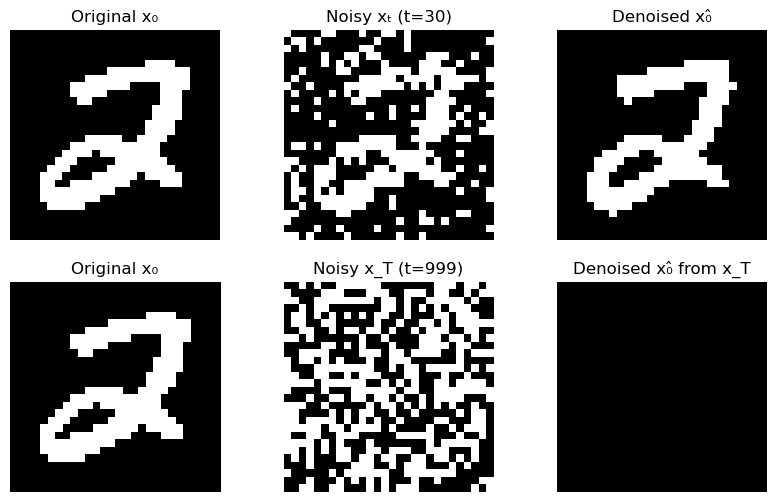


Epoch 3/30
  loss: 0.0027
  L_tminus1: 0.0001
  L0: 0.0000
  aux_ce: 0.2652
  steps: 469.0000
  lr: 0.0008

  Denoising metrics on full train set:
    At t=30:
      pixel_acc: 0.9641
      fg_acc: 0.8583
      bg_acc: 0.9802
      balanced_acc: 0.9193
      hamming: 0.0359
      mae: 0.0359
    At t=999 (final):
      pixel_acc: 0.8677
      fg_acc: 0.0000
      bg_acc: 1.0000
      balanced_acc: 0.5000
      hamming: 0.1323
      mae: 0.1323


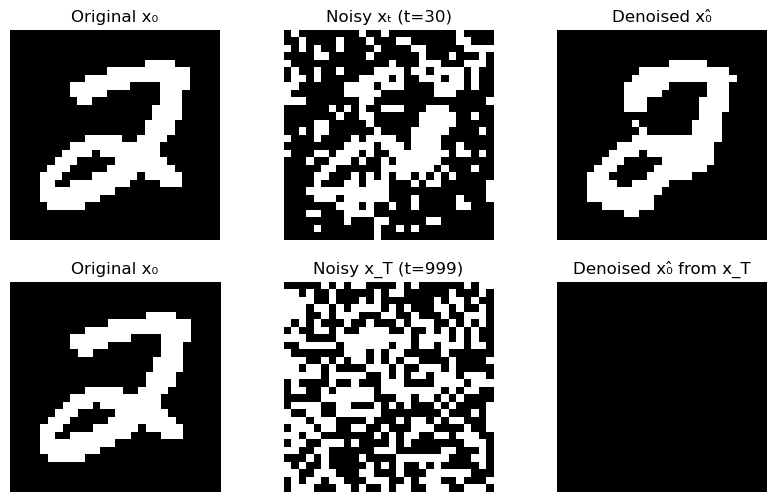


Epoch 6/30
  loss: 0.0027
  L_tminus1: 0.0001
  L0: 0.0000
  aux_ce: 0.2649
  steps: 469.0000
  lr: 0.0007


KeyboardInterrupt: 

In [31]:
history = trainer.train(num_epochs=30, save_every=None, validate=False, t_eval=30, print_every=3)


Epoch 1/30
  loss: 0.0028
  L_tminus1: 0.0001
  L0: 0.0000
  aux_ce: 0.2654
  steps: 469.0000
  lr: 0.0008

  Denoising metrics on full train set:
    At t=500:
      pixel_acc: 0.8677
      fg_acc: 0.0000
      bg_acc: 1.0000
      balanced_acc: 0.5000
      hamming: 0.1323
      mae: 0.1323
    At t=999 (final):
      pixel_acc: 0.8677
      fg_acc: 0.0000
      bg_acc: 1.0000
      balanced_acc: 0.5000
      hamming: 0.1323
      mae: 0.1323


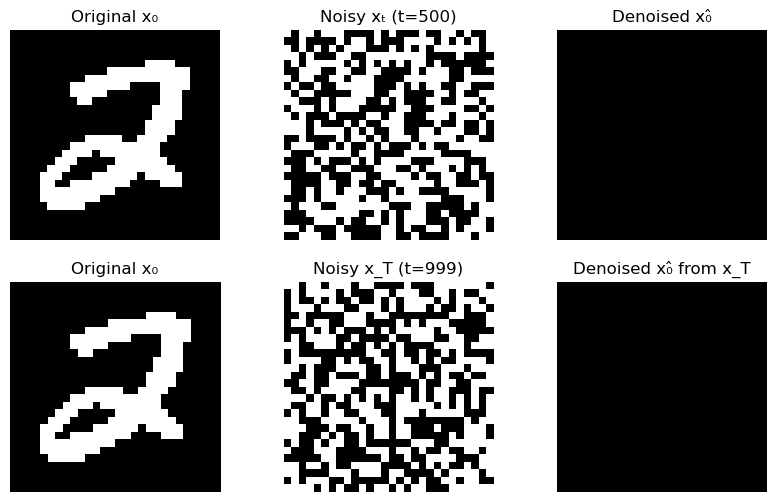


Epoch 3/30
  loss: 0.0028
  L_tminus1: 0.0001
  L0: 0.0000
  aux_ce: 0.2653
  steps: 469.0000
  lr: 0.0008

  Denoising metrics on full train set:
    At t=500:
      pixel_acc: 0.8677
      fg_acc: 0.0000
      bg_acc: 1.0000
      balanced_acc: 0.5000
      hamming: 0.1323
      mae: 0.1323
    At t=999 (final):
      pixel_acc: 0.8677
      fg_acc: 0.0000
      bg_acc: 1.0000
      balanced_acc: 0.5000
      hamming: 0.1323
      mae: 0.1323


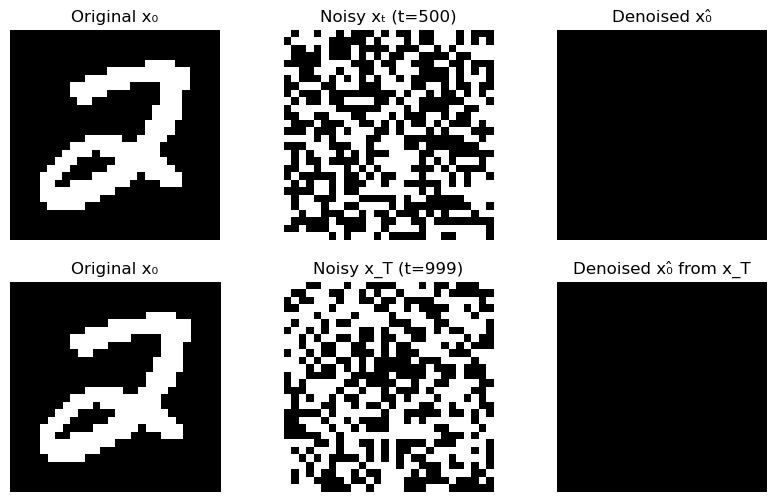

KeyboardInterrupt: 

In [30]:
history = trainer.train(num_epochs=30, save_every=None, validate=False, t_eval=500, print_every=3)